For this part we have more than one regressors. We will recycle most of the codes from the first part. 

From the problem set:
"In this part, you will implement linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

The file ex1data2.txt contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house."

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Check the data file
!head ../data/ex1data2.txt

2104,3,399900
1600,3,329900
2400,3,369000
1416,2,232000
3000,4,539900
1985,4,299900
1534,3,314900
1427,3,198999
1380,3,212000
1494,3,242500


In [42]:
#Import the data and add the titles
data = pd.read_csv('../data/ex1data2.txt', sep=",", header=None, names=['Size', 'Bedroom', 'Price'])
data.head()

,Size,Bedroom,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [4]:
data.describe()

,Size,Bedroom,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


Looking at the description of data, we see that the mean and standart deviation for regressors are on widely different scales. This matters because when we apply gradient descent, speed of convergence will differ across different axes. We need standardization of data

In [5]:
datac = (data - data.mean())/data.std()
datac.head()

,Size,Bedroom,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


I will import seaborn library again for the style

In [6]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set()

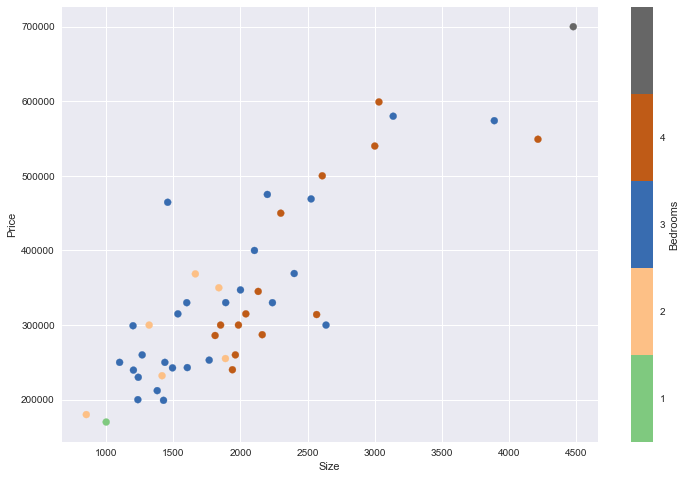

In [53]:
plt.figure(figsize=(12,8))
plt.scatter(data['Size'], data['Price'], c=data['Bedroom'],
            cmap=plt.cm.get_cmap('Accent', 5))
plt.xlabel('Size')
plt.ylabel('Price')
plt.colorbar(ticks=range(5), label='Bedrooms')
plt.clim(0.5, 5.5);

In [36]:
ones = np.ones(datac['Price'].shape[0])
datac['ones'] = ones
del(ones) #remove unused items
datac.head()

,Size,Bedroom,Price,ones
0,0.130010,-0.223675,0.475747,1.0
1,-0.504190,-0.223675,-0.084074,1.0
2,0.502476,-0.223675,0.228626,1.0
3,-0.735723,-1.537767,-0.867025,1.0
4,1.257476,1.090417,1.595389,1.0


In [41]:
cols = list(datac.columns)
cols = cols[-1:] + cols[:-1]
datac = datac[cols]
#del(cols)
datac.head()
#

,ones,Size,Bedroom,Price
0,1.0,0.130010,-0.223675,0.475747
1,1.0,-0.504190,-0.223675,-0.084074
2,1.0,0.502476,-0.223675,0.228626
3,1.0,-0.735723,-1.537767,-0.867025
4,1.0,1.257476,1.090417,1.595389


In [43]:
X = datac[cols[:-1]]
y = datac[cols[-1:]]
print(X.head(3))
print(y.head(3))
#We seperated explanatory and explained values

   ones      Size   Bedroom
0   1.0  0.130010 -0.223675
1   1.0 -0.504190 -0.223675
2   1.0  0.502476 -0.223675
      Price
0  0.475747
1 -0.084074
2  0.228626


In [44]:
X = np.matrix(X.values)
y = np.matrix(y.values)
#check the dimensions
X.shape, y.shape

((47, 3), (47, 1))

We'll use the same cost function as before since it was independent of the size of matrices

In [45]:
def cost_function(X, y, theta):
    """
    X is an n x k matrix of explanatory variables
    y is a n x 1 matrix of explained variables
    theta is a k x 1 matrix of multipliers for linear function
    """
    s = np.power(np.dot(X, theta) - y, 2)
    return np.sum(s) / (2 * X.shape[0])

In [46]:
theta = np.zeros(3).reshape(3,1)
cost_function(X, y, theta)

0.48936170212765967

Let's define the gradient descent function as well (It will update the multiplier)

In [47]:
def gradient_descent(X, y, theta, alpha):
    """
    This function will take in theta value and update it to a new one 
    according to gradient descent
    """
    errors = np.dot(X, theta) - y
    #errors will be calculated more than once, so let's do it once and store it
    temp_thet = np.zeros(theta.shape)
    for i, thet in enumerate(theta.ravel()): 
        #If not ravel, then it will take an array out of theta
        correction = np.sum(np.multiply(errors, X[:, i])) * alpha * (1.0 / X.shape[0])
        temp_thet[i, 0] = (thet - correction)
    return temp_thet

We can give it a try. Let's start with theta = (0, 0, 0) and alpha = 0.01 and see what the result will be, along the cost of the new multipliers.

In [49]:
theta = np.zeros(X.shape[1]).reshape(X.shape[1],1)
print(gradient_descent(X, y, theta, alpha=0.01))
print(cost_function(X, y, gradient_descent(X, y, theta, alpha=0.01)))

[[ -7.08652994e-19]
 [  8.36796367e-03]
 [  4.32851306e-03]]
0.480549104108


This cost value is an improvement to the one we found before:
0.48055 < 0.48936

That indicates we are on the right track

Now let's iterate on theta values to find the optimal theta. Along the way we will record the values for cost function as well

In [68]:
iterations = 1500
alpha = 0.01
theta_1 = np.zeros(X.shape[1]).reshape(X.shape[1],1)
cost_values = np.empty(iterations)
theta_values = np.empty((theta_1.shape[0], 1, iterations))

for i in range(iterations):
    cost_values[i] = cost_function(X, y, theta_1)
    theta_values[:, :, i] = theta_1
    theta_1 = gradient_descent(X, y, theta_1, alpha)
    
print(theta_1)
print(cost_function(X, y, theta_1))

[[ -1.10585300e-16]
 [  8.84042349e-01]
 [ -5.24551809e-02]]
0.130686706061


You can't draw the linear graph directly by using the older code from single variable case. The reason for that is the number of bedroom is not constant. I will draw parallel lines for different number of bedrooms.

I will just put the old code temporarily. I will change it. As you can see the we have a zig-zagging line since bedroom numbers are not fixed

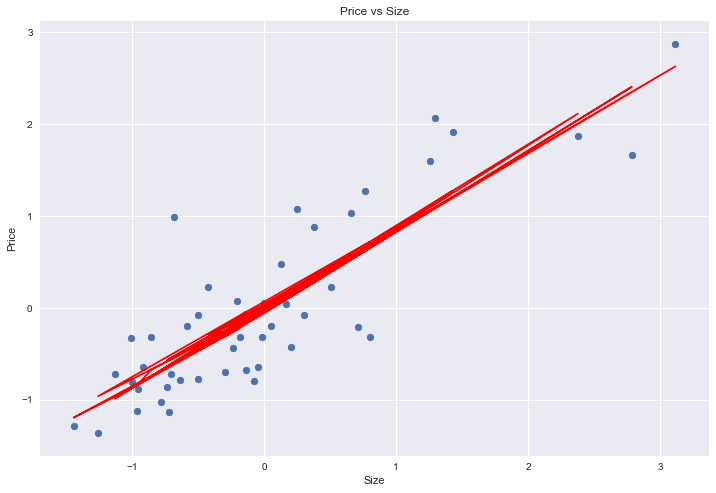

In [73]:
def lin_fun(X, theta):
    return np.dot(X, theta)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(X[:, 1], lin_fun(X, theta_1), color = 'r') 
#        label = 'Prediction = %0.2f + %0.2fx'%(theta_1[0],theta_1[1]))
ax.scatter(X[:, 1], y, label = 'Data')
#ax.legend(frameon = True, facecolor = "white")
#ax.set_xlabel('Population')
#ax.set_ylabel('Profit')
#ax.set_title('Profit vs Population');
#all of the commented above can be completed through ax.set
ax.set(xlabel = 'Size', ylabel = 'Price',
      title = 'Price vs Size');
#adding (xlim = (0, max(X[:, 1] + 2)), ylim = (-5, 25)) would set
#limits on x and y axes. Default limits are more aesthetic.

Here is the evolution of cost function. 

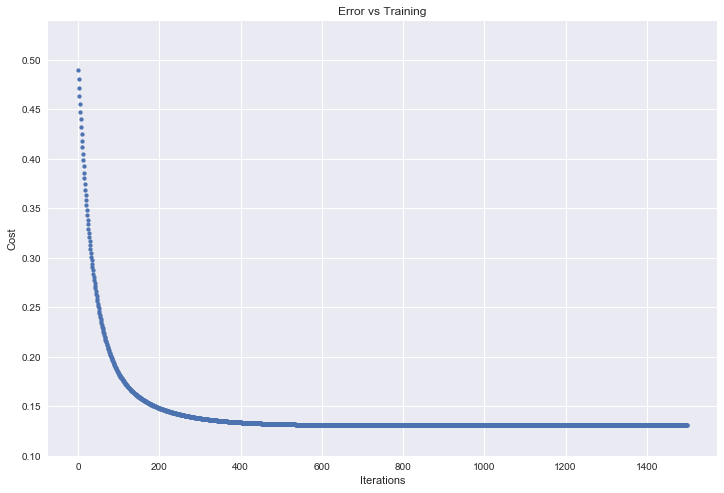

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(np.arange(0, iterations), cost_values, s = 15)
ax.set(ylim = (0.1, max(cost_values) + 0.05))
ax.set(xlabel = 'Iterations', ylabel = 'Cost',
      title = 'Error vs Training');